<small><i>June 2016 - This notebook was created by [Oriol Pujol Vila](http://www.maia.ub.es/~oriol). Source and [license](./LICENSE.txt) info are in the folder.</i></small>

# pill18 - Neural networks and deep learning

In [ ]:
#pip install tqdm

## Basic scheme

Consider the problem up to this point. Let us recall the three basic components of the algorithm. 

+ **The model class** 
+ **The loss function**
+ **The optimization algorithm**

Let us consider the following graph representation of the problem:
<img src = "pipeline1.png"  width = "200">

The model function is $f(x,\omega)$, where $\omega$ are the parameters to optimise. For example, in the case of a linear model we may have $f(x,\omega) = \sum_i \omega_i x_i = \omega^T x$. The loss function is represented with $\mathcal{L}(y,t)$, where $y=f(x,\omega)$ and $t$ is the target value. Remember that the loss function models the dissimilarity between the output of the model and the true value to predict. The last element of the learning algorithm is the optimisation algorithm. In our case is an algorithm with the goal of minimizing the dissimilarity between target value and the model output, i.e.

$$\underset{\omega}{\text{minimize}} \quad \mathcal{L}(f(x,\omega),t)$$

Let us refactor the code using OOP in order to take into account these three elements:

In [4]:
class model:
    def __init__(self):
        pass
    def forward(self,x):
        #Takes a data point and evaluates f(x,w)
        pass

class loss:
    def __init__(self):
        pass
    def evaluate(self,x,t):
        #Evaluates the loss function L(y,t)
        pass

class optimize:
    def __init__(self):
        pass
    def run(self, data, target, model, loss):
        #Takes a loss function and a model and find the optimal parameters for an specific data set
        pass
    

We know one way of optimising algorithms in front of large scale data sets, i.e. stochastic subgradient methods. In short this is an iterative algorithm that updates the unknown variables proportional to minus the gradient magnitude at each iteration. 

Let us fill in the gaps for a classical linear regression where the model is $f(x,\omega) = \omega^Tx$, 

In [5]:
import numpy as np
class model:
    def __init__(self,w):
        self.w = w
    def forward(self,x):
        #Takes a data point and evaluates f(x,w)
        return np.dot(self.w,x.T)

using a least squares loss function $\mathcal{L}(y,t) = (t-y)^2$,

In [6]:
class loss:
    def __init__(self):
        pass
    def evaluate(self,model,x,t):
        #Evaluates the loss function L(y,t)
        y = model.forward(x)
        return (t-y)*(t-y)

using stochastic gradient descend,

In [7]:
class optimize:
    def __init__(self,t):
        self.num_iter = t

    def run(self, data, target, model, loss):
        #Takes a loss function and a model and find the optimal parameters for an specific data set
        N_samples = data.shape[0]
        for t in xrange(self.num_iter):
            #Step 1.-take a sample x at random from the training set
            idx = np.random.randint(N_samples)
            xi = data[idx,:]
            yi = target[idx]
            
            #Step 2.- update the parameters to optimise
            model.w = model.w - eta * "gradient_L_omega(xi,yi)"
    

The gradient with respect to the parameter to optimise is $$\nabla_\omega\mathcal{L(f(x,\omega),t)} = (\frac{\partial \mathcal{L}}{\partial \omega_1},\frac{\partial \mathcal{L}}{\partial \omega_2}, \dots, \frac{\partial \mathcal{L}}{\partial \omega_d}) = \frac{\partial \mathcal{L}}{\partial \bar{\omega}}$$.

Recall the graph representation 
<img src = "pipeline1.png"  width = "200">
and consider the chain rule
$$\frac{\partial \mathcal{L}}{\partial \bar{\omega}} = \frac{\partial \mathcal{L}}{\partial y}\frac{\partial y}{\partial \bar{\omega}}$$

Observe that the complete differentiation is easier this way. 

Given that $\mathcal{L}(y,t) = (t-y)^2$, then 
$$\frac{\partial \mathcal{L}}{\partial y} = -2(t-y)$$

Given that $y = \omega^Tx$, then 
$$ \frac{\partial y}{\partial \bar{\omega}} = x$$

## The flow of the chain rule

Let us try to understand visually what the chain rule is about. This will constitute the basis of the backpropagation algorithm, that will be next used to train deep learning techniques and the basis of **automatic differentiation**, a programatically optimum way for computing differentials.

### Computational graph

Consider the following function $f(x,y,z) = (x+y)\cdot z$. The computational graph corresponds to a graphical representation of the operations.

<img src = "comp_graph1.jpg"  width = "300">

Each of the archs can be labelled. This lets us to introduce a midpoint $q$.

Let us now look at the partial derivatives of each node with respect of its inputs. We have 

$$\frac{\partial f}{\partial f} = 1$$
$$\frac{\partial f}{\partial q} = z$$
$$\frac{\partial f}{\partial z} = q$$
$$\frac{\partial q}{\partial x} = 1$$
$$\frac{\partial q}{\partial y} = 1$$

Now, if we ask about the gradient with respect to any of the inputs, we can readily use the chain rule,

$$\frac{\partial f}{\partial x} = \frac{\partial f}{\partial q} \frac{\partial q}{\partial x} = z \cdot 1$$

$$\frac{\partial f}{\partial y} = \frac{\partial f}{\partial q} \frac{\partial q}{\partial y} = z\cdot 1$$

$$\frac{\partial f}{\partial z} = q $$


This flow is the basic idea behind **automatic differentiation** or **algorithmic differentiation**. The idea is we can create a computational graph, and take advantage of this parsing to readily compute differentials (or store the operations involved) as we parse the graph. There are two flavours of automatic differentiation, **forward** and **backward**. Corresponding to two different views of operating using the chain rule, e.g. given the following chain

$$\frac{\partial f}{\partial x} = \frac{\partial f}{\partial q} \frac{\partial q}{\partial u}\frac{\partial q}{\partial x},$$

we can operate, from the start of the graph in a forward mode, this is

$$\frac{\partial f}{\partial x} = \frac{\partial f}{\partial q} \big(\frac{\partial q}{\partial u}\frac{\partial q}{\partial x}\big),$$

or backwards, starting from the end of the graph

$$\frac{\partial f}{\partial x} = \big(\frac{\partial f}{\partial q} \frac{\partial q}{\partial u}\big)\frac{\partial q}{\partial x}.$$

Forward autodiff is usually interesting when we are in front of a vectorial function and we need to compute its Jacobian, i.e. $$F(x) = (f_1(x),f_2(x), \dots, f_N(x))$$ and we want to compute the Jacobian $$\frac{\partial F}{\partial x} = (\frac{\partial f_1(x)}{\partial x},\dots, \frac{\partial f_N(x)}{\partial x})$$.

Backward differentiation is particularly useful when computing gradients, this is given a function $f(x_1,\dots,x_N)$, its gradient is $$\nabla f = (\frac{\partial f}{\partial x_1},\dots,\frac{\partial f}{\partial x_N}).$$



In [8]:
class optimize:
    def __init__(self):
        pass

    def run(self, data, target, model, loss, num_iter, eta):
        #Takes a loss function and a model and find the optimal parameters for an specific data set
        N_samples = data.shape[0]
        for t in range(num_iter):
            #Step 1.-take a sample x at random from the training set
            idx = np.random.randint(N_samples)
            xi = data[idx,:]
            yi = target[idx]
            
            #Step 2.- update the parameters to optimise
            model.w = model.w - eta * loss.gradient(model,xi,yi)*model.gradient(xi)

Thus we need to add the gradient terms to the model and the loss.

In [9]:
import numpy as np
class model:
    def __init__(self,d):
        self.w = np.zeros((1,d+1))
    def forward(self,x):
        #Takes a data point and evaluates f(x,w)
        return np.dot(self.w[0,:-1],x.T)+self.w[0,-1]
    def gradient(self,x):
        return np.concatenate((x,np.array([1])))
    def gradient_x(self,x):
        return self.w[0,:-1]

In [10]:
class loss:
    def __init__(self):
        self.y = 0
        
    def evaluate(self,model,x,t):
        #Evaluates the loss function L(y,t)
        self.y = model.forward(x)
        return (t-self.y)*(t-self.y)
    
    def gradient(self,model,x,t):
        self.y = model.forward(x)
        return -2.*(t-self.y)

Let us put all the pieces together and solve a toy problem

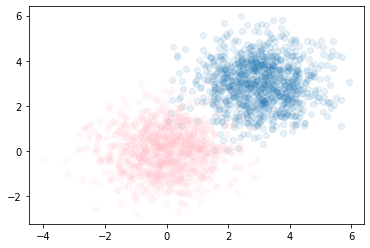

In [11]:
import numpy as np

#Example dataset
N_samples_per_class = 1000
d_dimensions = 2
x = np.vstack((np.random.randn(N_samples_per_class, d_dimensions),np.random.randn(N_samples_per_class, d_dimensions)+np.array([3,3])))
y = np.vstack((-1.*np.ones((N_samples_per_class,1)),1.*np.ones((N_samples_per_class,1))))

%matplotlib inline
import matplotlib.pyplot as plt

idx = y==1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.1)
idx = y==-1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.1,color='pink')

/var/folders/df/4599m83s2vj4j1_h__gx7kqw0000gn/T/ipykernel_1415/1664098184.py:20: UserWarning: No contour levels were found within the data range.
  plt.contour(XX,YY,Z,[0])


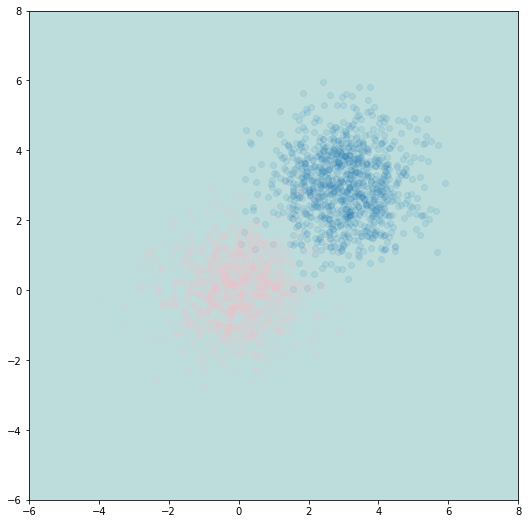

In [12]:
delta = 0.05
xx = np.arange(-5.0, 8.0, delta)
yy = np.arange(-5.0, 8.0, delta)
XX, YY = np.meshgrid(xx, yy)
Xf = XX.flatten()
Yf = YY.flatten()
sz=XX.shape
test_data = np.concatenate([Xf[:,np.newaxis],Yf[:,np.newaxis]],axis=1);

idx = y==1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.1)
idx = y==-1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.1,color='pink')

f=model(d_dimensions)
Z = f.forward(test_data)
Z.shape=sz

plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-6,8,-6,8),alpha=0.3, vmin=-15, vmax=15)
plt.contour(XX,YY,Z,[0])
fig = plt.gcf()
fig.set_size_inches(9,9)

Let us add some control to check how it works. We will compute the loss every 1000 iterations, just for  checking purposes and add a plot method for showing convergence.

In [13]:
import matplotlib.pyplot as plt
class optimize:
    def __init__(self):
        pass

    def run(self, data, target, model, loss, num_iter, eta):
        #Takes a loss function and a model and find the optimal parameters for an specific data set
        self.l = np.zeros((int(np.ceil(num_iter/1000.)),1))
        N_samples = data.shape[0]
        i=0
        for t in range(num_iter):
            #Step 1.-take a sample x at random from the training set
            idx = np.random.randint(N_samples)
            xi = data[idx,:]
            yi = target[idx]
            # <-- Start new code
            if t%1000==0:
                self.l[i] = np.sum(loss.evaluate(model,data[:1000,:],target[:1000,0]))
                i=i+1
            ## End new code -->
            #Step 2.- update the parameters to optimise
            model.w = model.w - eta * loss.gradient(model,xi,yi)*model.gradient(xi)
    def plot(self):
        plt.plot(self.l)
        

Now let us run the method.

In [14]:
num_iter = 100000
eta = 0.001 #optimization step/learning rate

f = model(d_dimensions)
L = loss()
opt = optimize()
opt.run(x,y,f,L,num_iter,eta)

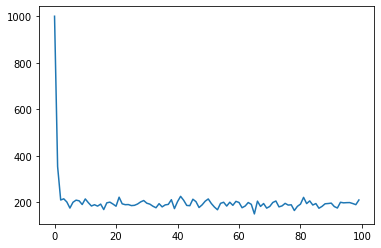

In [15]:
opt.plot()

Let us visually check the results

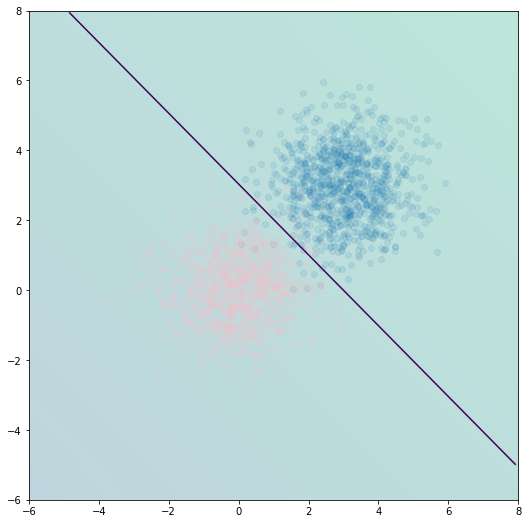

In [16]:
delta = 0.05
xx = np.arange(-5.0, 8.0, delta)
yy = np.arange(-5.0, 8.0, delta)
XX, YY = np.meshgrid(xx, yy)
Xf = XX.flatten()
Yf = YY.flatten()
sz=XX.shape
test_data = np.concatenate([Xf[:,np.newaxis],Yf[:,np.newaxis]],axis=1);

idx = y==1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.1)
idx = y==-1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.1,color='pink')

Z = f.forward(test_data)
Z.shape=sz

plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-6,8,-6,8),alpha=0.3, vmin=-15, vmax=15)
plt.contour(XX,YY,Z,[0])
fig = plt.gcf()
fig.set_size_inches(9,9)

---
---
NOTES 
---

**We have a linear model and we wish to get 100% accuracy**:
- we could remove the errors
- We could change the weights so we minimize the loss: $w_{t+1} = w_t - \eta \nabla w \mathcal{L}$. Instead we could either study in which way we have to move the data in order to minimize the loss $x_{t+1} = x_t - \eta \nabla x \mathcal{L}$. Then according to the fixed line, we could move the data until we get 100% accuracy. We move then the data, using first the Hinge loss. This is the basis of many pool fixs. 

Let's suppose now we have Bethoven symphony and we seek to find a classifier that identifies the music. We get as an output Reggeton. We could change the data until we get a correct output, then the data will switch until it is close enough to reggeton. 

Consider as well deep dreaming, which also consists of changing the data until we get the closest thing to the output


## Deep learning

Deep learning is based on uodating the weigths of the previous layer by minimizing the derivative of the output of each layer with respect to the weigths: **backward propagation**. 

---
---

## Just for fun. 

Let us create a new loss function more adequate for classification purposes. The hinge loss

$\mathcal{L}(y,t) = \max(0, 1-t\cdot y)$

In [17]:
#display
class loss_hinge:
    def __init__(self):
        self.y = 0
        
    def evaluate(self,model,x,t):
        #Evaluates the loss function L(y,t)
        self.y = model.forward(x)
        return np.maximum(0,1-t*self.y)
    
    def gradient(self,model,x,t):
        self.y = model.forward(x)
        if (1-t*self.y)>0:
            return -t
        else:
            return 0


In [18]:
num_iter = 10000
eta = 0.01 #optimization step/learning rate

f = model(d_dimensions)
L = loss_hinge()
opt = optimize()
opt.run(x,y,f,L,num_iter,eta)

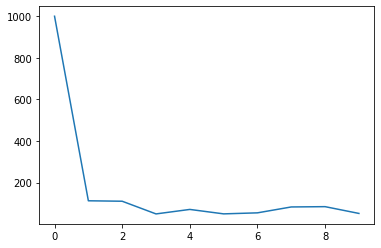

In [19]:
opt.plot()

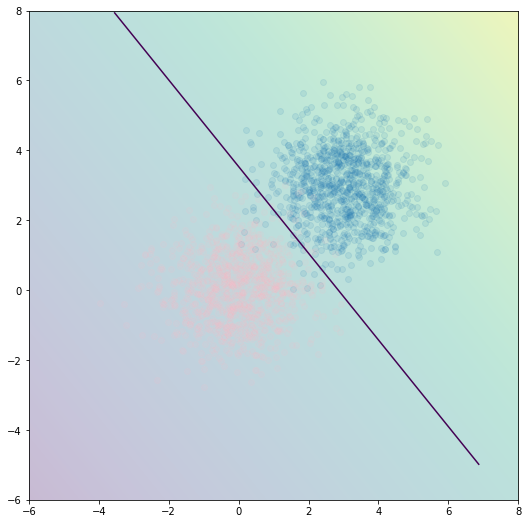

In [20]:
delta = 0.05
xx = np.arange(-5.0, 8.0, delta)
yy = np.arange(-5.0, 8.0, delta)
XX, YY = np.meshgrid(xx, yy)
Xf = XX.flatten()
Yf = YY.flatten()
sz=XX.shape
test_data = np.concatenate([Xf[:,np.newaxis],Yf[:,np.newaxis]],axis=1);

idx = y==1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.1)
idx = y==-1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.1,color='pink')

Z = f.forward(test_data)
Z.shape=sz

plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-6,8,-6,8),alpha=0.3, vmin=-15, vmax=15)
plt.contour(XX,YY,Z,[0])
fig = plt.gcf()
fig.set_size_inches(9,9)

## Even more fun

We still do not have a perfect result. But we could modify the data set so that our classifier solves the problem perfectly. Remember that the gradient can be seen as what change we must made to a certain variable in order to maximize some cost function. What if the variable is data? This would mean how should we change data for a perfect classification?.

Let us create a new optimizer in order to update data.

<div class = "alert alert-info" style="border-radius:10px">**EXERCISE: ** Discuss how can we change the problem to get a perfect classification. Fill the blank in the code to check it.</div>

> **We have a linear model and we wish to get 100% accuracy**:
- we could remove the errors
- We could change the weights so we minimize the loss: $w_{t+1} = w_t - \eta \nabla w \mathcal{L}$. Instead we could either study in which way we have to move the data in order to minimize the loss $x_{t+1} = x_t - \eta \nabla x \mathcal{L}$. Then according to the fixed line, we could move the data until we get 100% accuracy. We move then the data, using first the Hinge loss. This is the basis of many pool fixs. 


In [25]:
# your code

from IPython.display import clear_output, Image, display
%matplotlib inline

class optimize_data:
    def __init__(self):
        pass

    def run(self, data, target, model, loss, num_iter, eta):
        #Takes a loss function and a model and find the optimal parameters for an specific data set
        N_samples = data.shape[0]
        for t in range(num_iter):
            

            #Step 1.-take a sample x at random from the training set
            idx = np.random.randint(N_samples)
            xi = data[idx,:]
            yi = target[idx,:]
            
            #Step 2.- update the parameters to optimise
            data[idx,:] = data[idx,:] - eta * np.dot(layer.gradient(),dLdx.T)
        return data

Let us train a classifier first.

In [26]:
num_iter = 100000
eta = 0.001 #optimization step/learning rate

f = model(d_dimensions)
L = loss_hinge()
opt = optimize()
opt.run(x,y,f,L,num_iter,eta)

Now we check the results and see that the result is good but does not classify all data perfectly. 

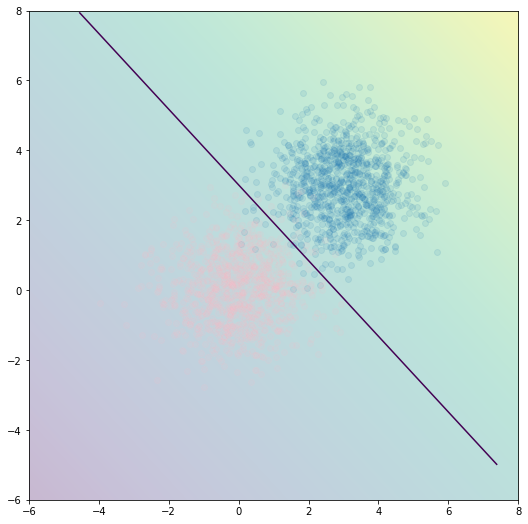

In [27]:
delta = 0.05
xx = np.arange(-5.0, 8.0, delta)
yy = np.arange(-5.0, 8.0, delta)
XX, YY = np.meshgrid(xx, yy)
Xf = XX.flatten()
Yf = YY.flatten()
sz=XX.shape
test_data = np.concatenate([Xf[:,np.newaxis],Yf[:,np.newaxis]],axis=1);

idx = y==1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.1)
idx = y==-1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.1,color='pink')

Z = f.forward(test_data)
Z.shape=sz

plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-6,8,-6,8),alpha=0.3, vmin=-15, vmax=15)
plt.contour(XX,YY,Z,[0])
fig = plt.gcf()
fig.set_size_inches(9,9)

And now, modify the data so that the trained classifier classifies all data points. 

In [28]:
num_iter = 500000
eta = 0.05 #optimization step/learning rate
x_orig = x.copy()
Lh = loss_hinge()
opt = optimize_data()
x_mod = opt.run(x_orig,y,f,Lh,num_iter,eta)


NameError: name 'layer' is not defined

In [25]:
delta = 0.05
xx = np.arange(-5.0, 8.0, delta)
yy = np.arange(-5.0, 8.0, delta)
XX, YY = np.meshgrid(xx, yy)
Xf = XX.flatten()
Yf = YY.flatten()
sz=XX.shape
test_data = np.concatenate([Xf[:,np.newaxis],Yf[:,np.newaxis]],axis=1);

idx = y==1
plt.scatter(x_mod[idx.ravel(),0],x_mod[idx.ravel(),1],alpha=0.1)
idx = y==-1
plt.scatter(x_mod[idx.ravel(),0],x_mod[idx.ravel(),1],alpha=0.4,color='pink')

Z = f.forward(test_data)
Z.shape=sz

plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-6,8,-6,8),alpha=0.3, vmin=-15, vmax=15)
plt.contour(XX,YY,Z,[0])
fig = plt.gcf()
fig.set_size_inches(9,9)

NameError: name 'x_mod' is not defined

# Deep models

Deep models are defined as the composition or stacking of functions. For example, consider the following graph

<img src="pipeline2.png" width = "300">

where 

$$y_2 = f_2(f_1(x)).$$

Observe that we are just changing the model while the loss and the optimization function remains the same.

Different to the other case the parameters are arranged in layers. Thus the computation of the gradient with respect to the parameters is a little more involved. However, we will use standard chain rule. In this case we want to find 

$$\frac{\partial \mathcal{L}}{\partial \bar{\omega_2}} = \frac{\partial \mathcal{L}}{\partial y_2}\frac{\partial y_2}{\partial \bar{\omega_2}}$$
and
$$\frac{\partial \mathcal{L}}{\partial \bar{\omega_1}} = \frac{\partial \mathcal{L}}{\partial y_2}\frac{\partial y_2}{\partial \bar{y_1}}\frac{\partial \bar{y_1}}{\partial \bar{\omega_1}}$$

Observe that this decomposition allows to decouple each layer in the following terms
$$\frac{\partial \mathcal{L}}{\partial \bar{\omega_1}} = \frac{\partial \mathcal{L}}{\partial \bar{y_1}}\frac{\partial \bar{y_1}}{\partial \bar{\omega_1}}$$

In general for $N$ layers the update of the parameters of the $m$-th layer is written as 
$$\frac{\partial \mathcal{L}}{\partial \bar{\omega_m}} = \frac{\partial \mathcal{L}}{\partial \bar{y_m}}\frac{\partial \bar{y_m}}{\partial \bar{\omega_m}} = \frac{\partial \mathcal{L}}{\partial \bar{y_N}}\prod\limits_{i=m}^{N-1}\frac{\partial \bar{y_{i+1}}}{\partial \bar{y_i}} \frac{\partial \bar{y_m}}{\partial \bar{\omega_m}}$$

Thus we have to define for each layer two gradients:
+ *the gradient with respect to the parameters* is the one used for updating the parameters
+ *the gradient with respect to the layer input* is the one needed to move backward the gradient of the loss and will be used for updating lower layers.

This is what it is called **backpropagation**.

In [29]:
import numpy as np

class layer:
    def __init__(self):
        pass
    def forward(self): # evaluate the layer
        pass
    def backward(self): # gradient with respect to the inputs
        pass
    def gradient(self): # gradient with respect to the parameters
        pass
    

In [30]:

class reluLayer(layer): #this is a linear layer with relu activation
    def __init__(self,input_dim,n_neurons):
        self.x = np.zeros((1,input_dim))
        self.z = np.zeros((1,n_neurons))
        self.w = np.random.randn(input_dim,n_neurons)
        self.y = np.zeros((1,n_neurons))
    def forward(self,x): # evaluate the layer max(0, w^T * x)
        self.z = np.dot(x, self.w)
        self.y = np.maximum(0,self.z)
        return self.y
    def backward(self): # gradient with respect to the inputs
        return np.select([self.z>0],[self.w],default=0).T
    def gradient(self): # gradient with respect to the parameters
        dydz = np.where(self.z>0,1.,0.)
        return np.dot(dydz[:,np.newaxis],self.x).T   

class model:
    def __init__(self):
        self.architecture = []
        self.y_ = []
    def addLayer(self,layer):
        self.architecture.append(layer)
    def forward(self,x):
        #Takes a data point and evaluates f(x,w)
        self.y_= x
        for layer in self.architecture:
            self.y_=layer.forward(self.y_)
        return self.y_


In [31]:
class optimize:
    def __init__(self):
        pass

    def run(self, data, target, model, loss, num_iter, eta):
        ## Stochastic gradient descent as always!
        #Takes a loss function and a model and find the optimal parameters for an specific data set
        N_samples = data.shape[0]
        for t in range(num_iter):
            #Step 1.-take a sample x at random from the training set
            idx = np.random.randint(N_samples)
            xi = data[idx,:]
            yi = target[idx,:]
            
            #Step 2.- update the parameters to optimise
            dLdx= loss.gradient(model,xi,yi)[:,np.newaxis]
            for layer in reversed(model.architecture):
                tmp = layer.w - eta * np.dot(layer.gradient(),dLdx.T)
                dLdx = np.dot(dLdx,layer.backward())
                layer.w = tmp


In [32]:
num_iter = 10000
eta = 0.01 #optimization step/learning rate
nn = model()
nn.addLayer(reluLayer(2,10))
nn.addLayer(reluLayer(10,100))
nn.addLayer(reluLayer(100,30))
nn.addLayer(reluLayer(30,10))
nn.addLayer(reluLayer(10,1))
L = loss()
opt = optimize()
x_mod = opt.run(x,y,nn,L,num_iter,eta)

/var/folders/df/4599m83s2vj4j1_h__gx7kqw0000gn/T/ipykernel_1415/1372398240.py:19: UserWarning: No contour levels were found within the data range.
  plt.contour(XX,YY,Z,[0])


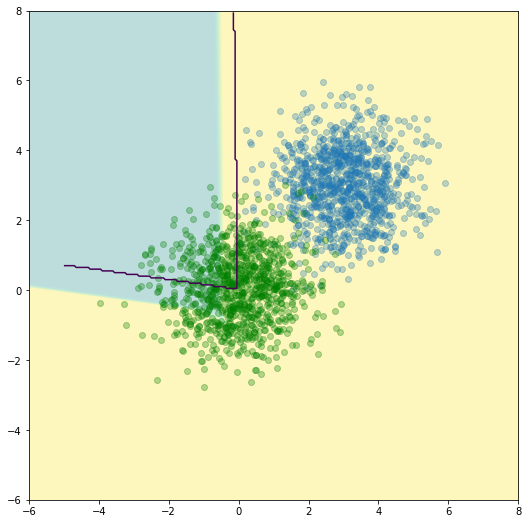

In [33]:
delta = 0.05
xx = np.arange(-5.0, 8.0, delta)
yy = np.arange(-5.0, 8.0, delta)
XX, YY = np.meshgrid(xx, yy)
Xf = XX.flatten()
Yf = YY.flatten()
sz=XX.shape
test_data = np.concatenate([Xf[:,np.newaxis],Yf[:,np.newaxis]],axis=1);

idx = y==1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.3)
idx = y==-1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.3,color='green')

Z = nn.forward(test_data)
Z.shape=sz

plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-6,8,-6,8),alpha=0.3, vmin=-15, vmax=15)
plt.contour(XX,YY,Z,[0])
fig = plt.gcf()
fig.set_size_inches(9,9)

# All together now

In [34]:
class loss:
    def __init__(self):
        self.y = 0    
    def evaluate(self,model,x,t):
        #Evaluates the loss function L(y,t)
        self.y = model.forward(x)
        return (t-self.y)*(t-self.y)
    def gradient(self,model,x,t):
        self.y = model.forward(x)
        return -2.*(t-self.y)
    
class reluLayer(layer): #this is a linear layer with relu activation
    def __init__(self,input_dim,n_neurons):
        self.x = np.zeros((1,input_dim))
        self.z = np.zeros((1,n_neurons))
        self.w = np.random.randn(input_dim,n_neurons) #Normal Random Initialization
        self.y = np.zeros((1,n_neurons))
    def forward(self,x): # evaluate the layer
        self.z = np.dot(x, self.w)
        self.y = np.maximum(0,self.z)
        return self.y
    def backward(self): # gradient with respect to the inputs
        return np.select([self.z>0],[self.w],default=0).T
    def gradient(self): # gradient with respect to the parameters
        dydz = np.where(self.z>0,1.,0.)
        return np.dot(dydz[:,np.newaxis],self.x).T   

class model:
    def __init__(self):
        self.architecture = []
        self.y_ = []
    def addLayer(self,layer):
        self.architecture.append(layer)
    def forward(self,x):
        #Takes a data point and evaluates f(x,w)
        self.y_= x
        for layer in self.architecture:
            self.y_=layer.forward(self.y_)
        return self.y_

class optimize:
    def __init__(self):
        pass

    def run(self, data, target, model, loss, num_iter, eta):
        #Takes a loss function and a model and find the optimal parameters for an specific data set
        N_samples = data.shape[0]
        for t in xrange(num_iter):
            #Step 1.-take a sample x at random from the training set
            idx = np.random.randint(N_samples)
            xi = data[idx,:]
            yi = target[idx,:]
            
            #Step 2.- update the parameters to optimise
            dLdx= loss.gradient(model,xi,yi)[:,np.newaxis]
            for layer in reversed(model.architecture):
                layer.w = layer.w - eta * np.dot(layer.gradient(),dLdx.T)
                dLdx = np.dot(dLdx,layer.backward())

# All together now ... with bias

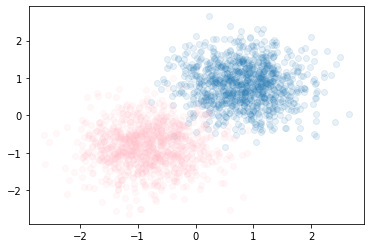

In [35]:
import numpy as np

#Example dataset
N_samples_per_class = 1000
d_dimensions = 2
x = np.vstack((np.random.randn(N_samples_per_class, d_dimensions),np.random.randn(N_samples_per_class, d_dimensions)+np.array([3,3])))
y = np.vstack((-1.*np.ones((N_samples_per_class,1)),1.*np.ones((N_samples_per_class,1))))


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x = scaler.fit_transform(x)


%matplotlib inline
import matplotlib.pyplot as plt

idx = y==1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.1)
idx = y==-1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.1,color='pink')

In [36]:
import numpy as np
#import tqdm

class loss:
    def __init__(self):
        self.y = 0    
    def evaluate(self,model,x,t):
        #Evaluates the loss function L(y,t)
        self.y = model.forward(x)
        return (t-self.y)*(t-self.y)
    def gradient(self,model,x,t):
        self.y = model.forward(x)
        return -2.*(t-self.y)
    
class reluLayer(layer): #this is a linear layer with relu activation
    def __init__(self,input_dim,n_neurons):
        self.z = np.zeros((1,n_neurons))
        self.w = np.random.randn(input_dim+1,n_neurons) 
        #self.w = self.w/np.dot(np.ones((input_dim+1,1)),np.sum(self.w*self.w,axis=0)[np.newaxis,:])
        self.y = np.zeros((1,n_neurons))
    def forward(self,x): # evaluate the layer
        self.xext = np.concatenate((x,np.ones((x.shape[0],1))),axis=1)
        self.z = np.dot(self.xext, self.w)
        self.y = np.maximum(0,self.z)
        return self.y
    def backward(self): # gradient with respect to the inputs
        dydz = np.tile(np.where(self.z>0.,1.,0.),(self.w.shape[0],1))
        tw = dydz*self.w
        return tw[:-1,:] 
    def gradient(self): # gradient with respect to the parameters
        dydz = np.where(self.z>0.,1.,0.)
        return np.dot(dydz.T,self.xext)
    
class linearLayer(layer): #this is a linear layer with relu activation
    def __init__(self,input_dim,n_neurons):
        self.w = np.random.randn(input_dim+1,n_neurons) 
        self.y = np.zeros((1,n_neurons))
    def forward(self,x): # evaluate the layer
        self.xext = np.concatenate((x,np.ones((x.shape[0],1))),axis=1)
        self.y = np.dot(self.xext, self.w)
        return self.y
    def backward(self): # gradient with respect to the inputs
        return self.w[:-1,:] 
    def gradient(self): # gradient with respect to the parameters
        return self.xext

class model:
    def __init__(self):
        self.architecture = []
        self.y_ = []
    def addLayer(self,layer):
        self.architecture.append(layer)
    def forward(self,x):
        #Takes a data point and evaluates f(x,w)
        self.y_= x
        for layer in self.architecture:
            self.y_=layer.forward(self.y_)
        return self.y_

class optimize:
    def __init__(self, debug = False, plot_convergence = 10.):
        self.debug_ = debug
        self.pc = plot_convergence
        
    def run(self, data, target, model, loss, num_iter, eta):
        #Takes a loss function and a model and find the optimal parameters for an specific data set
        self.l = np.zeros((int(np.ceil((num_iter*1.0)/self.pc)),1))
        print( self.l.shape)
        i=0
        
        N_samples = data.shape[0]
        print(N_samples)

        #for t in tqdm.tqdm(xrange(num_iter)):
        for t in range(num_iter):
            #Step 1.-take a sample x at random from the training set
            idx = np.random.randint(N_samples)
            xi = data[idx,:]
            xi = xi[np.newaxis,:]
            yi = target[idx,:]
            
            if (t*1.)%self.pc==0:
                self.l[i] = np.sum(loss.evaluate(model,data,target))
                i=i+1
            
            #Step 2.- update the parameters to optimise
            dLdx= loss.gradient(model,xi,yi)
            for layer in reversed(model.architecture):
                if self.debug_:
                    print( "xi"+str(xi.shape))
                    print( "g"+str(layer.gradient().shape))
                    print( "dLdx"+str(dLdx.shape))
                    print( "w"+str(layer.w.shape))
                    print( "b"+str(layer.backward().shape))
                tmp = layer.w - eta * np.dot(dLdx,layer.gradient()).T
                dLdx = np.dot(dLdx,layer.backward().T)
                layer.w = tmp
    def plot(self):
        plt.plot(self.l)

(100, 1)
2000


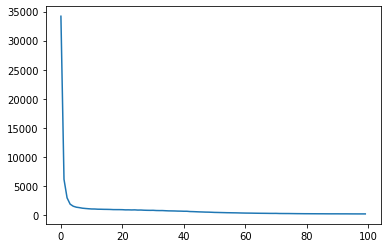

In [37]:
num_iter = 10000
eta = 0.001 #optimization step/learning rate
nn = model()
nn.addLayer(reluLayer(2,10))
nn.addLayer(linearLayer(10,1))
L = loss()
opt = optimize(plot_convergence=100)
x_mod = opt.run(x,y,nn,L,num_iter,eta)
opt.plot()

In [38]:
np.sum(L.evaluate(nn,x,y))

150.97859842191215

(array([ 21.,  97., 527., 271.,  30.,  23.,  19.,  19.,  40., 953.]),
 array([-1.75689848, -1.48098793, -1.20507738, -0.92916683, -0.65325628,
        -0.37734574, -0.10143519,  0.17447536,  0.45038591,  0.72629646,
         1.00220701]),
 <BarContainer object of 10 artists>)

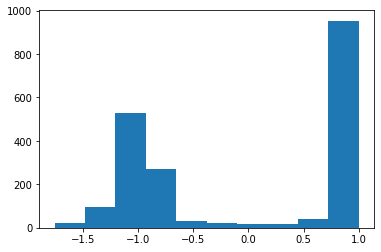

In [39]:
plt.hist(nn.forward(x))


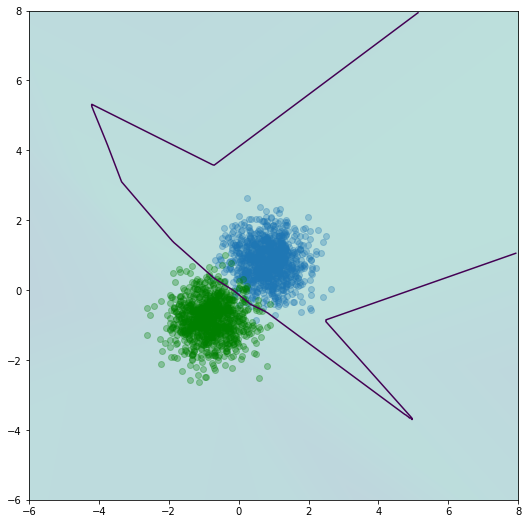

In [40]:
delta = 0.05
xx = np.arange(-5.0, 8.0, delta)
yy = np.arange(-5.0, 8.0, delta)
XX, YY = np.meshgrid(xx, yy)
Xf = XX.flatten()
Yf = YY.flatten()
sz=XX.shape
test_data = np.concatenate([Xf[:,np.newaxis],Yf[:,np.newaxis]],axis=1);

idx = y==1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.3)
idx = y==-1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.3,color='green')

Z = nn.forward(test_data)
Z.shape=sz

plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-6,8,-6,8),alpha=0.3, vmin=-15, vmax=15)
plt.contour(XX,YY,Z,[0])
fig = plt.gcf()
fig.set_size_inches(9,9)

In [41]:
def test_forward():
    nn = model()
    nn.addLayer(reluLayer(2,1))
    w = np.ndarray((3,1), buffer=np.array([1.,2.,0.]))
    nn.architecture[0].w = w
    x = np.ndarray((1,2), buffer=np.array([-0.1,0.1]))
    assert nn.forward(x)==0.1, nn.forward(x)
    nn = model()
    nn.addLayer(reluLayer(2,1))
    w = np.ndarray((3,1), buffer=np.array([1.,2.,0.]))
    nn.architecture[0].w = w
    x = np.ndarray((1,2), buffer=np.array([0.1,-0.1]))
    assert nn.forward(x)==0., nn.forward(x)
    
def test_gradient():
    nn = model()
    nn.addLayer(reluLayer(2,1))
    w = np.ndarray((3,1), buffer=np.array([1.,2.,0.]))
    nn.architecture[0].w = w
    x = np.ndarray((1,2), buffer=np.array([-0.1,0.1]))
    l = loss()
    eg = np.ndarray((1,3), buffer=np.array([-0.1,0.1,1.]))
    eb = np.ndarray((2,1), buffer=np.array([1.,2.]))
    #Step 2.- update the parameters to optimise
    dLdx= l.gradient(nn,x,y)
    for layer in reversed(nn.architecture):
        assert np.all(np.equal(layer.gradient(),eg)), layer.gradient()
        assert np.all(np.equal(layer.backward(),eb)), layer.backward()

        
    
def test_loss():
    nn = model()
    nn.addLayer(reluLayer(2,1))
    w = np.ndarray((3,1), buffer=np.array([1.,2.,0.]))
    nn.architecture[0].w = w
    l = loss()
    x = np.ndarray((1,2), buffer=np.array([-0.1,0.1]))
    t=1.
    assert l.evaluate(nn,x,t)==0.81, "Expected 0.81, returned: "+str(l.evaluate(nn,x,t))
    assert l.gradient(nn,x,t)==-1.8, "Expected -1.8, returned: "+str(l.gradient(nn,x,t))

test_forward()
test_loss()
test_gradient()

## Bonus: Behavior in general acyclic directed graphs structures

In general, we may have a workflow that involves an acyclic directed graph. If that is the case we find two new elements where gradient is involved, splitting nodes and joint nodes. 

Consider an splitting node. How will backpropagation work in that case?

<img src="split.png" width="150">

Looking at the picture we realise that 
$$(y_1,y_2)=f(x,\omega) = (f_1(x,\omega),f_2(x,\omega)).$$

Remember that in backpropagation we need to define two derivatives, the update derivative $\frac{\partial \mathcal{L}}{\partial \omega}$ and the backpropagation derivative $\frac{\partial \mathcal{L}}{\partial x}$.

Remember that at any layer we are able to define these two quantities as soon as we have $\frac{\partial \mathcal{L}}{\partial \bar{y}} = (\frac{\partial \mathcal{L}}{\partial y_1}, \frac{\partial \mathcal{L}}{\partial y_2})$. 

Again we use the differentiation chain rule, 

$$\frac{\partial \mathcal{L}}{\partial \omega} = \frac{\partial \mathcal{L}}{\partial \bar{y}}^T\frac{\partial \bar{y}}{\partial \omega}$$
As stated in the former lines
$$\frac{\partial \mathcal{L}}{\partial \bar{y}} = (\frac{\partial \mathcal{L}}{\partial y_1},\frac{\partial \mathcal{L}}{\partial y_2})^T$$
and 

$$\frac{\partial \bar{y}}{\partial \omega} = (\frac{\partial y_1}{\partial \omega},\frac{\partial y_2}{\partial \omega})^T$$

Thus, 
$$\frac{\partial \mathcal{L}}{\partial \omega} = (\frac{\partial \mathcal{L}}{\partial y_1},\frac{\partial \mathcal{L}}{\partial y_2})^T \left(\begin{matrix}\frac{\partial y_1}{\partial \omega}\\ \frac{\partial y_2}{\partial \omega}\end{matrix}\right) = $$

$$= \frac{\partial \mathcal{L}}{\partial y_1} \frac{\partial y_1}{\partial \omega} + \frac{\partial \mathcal{L}}{\partial y_2}\frac{\partial y_2}{\partial \omega}$$

Observe that the influence of both gradients backpropagating through the graph is added.